# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using Turi Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Turi Create

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import turicreate

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [8]:
types = {
    "bathrooms": float,
    "waterfront": int,
    "sqft_above": int,
    "sqft_living15": float,
    "grade": int,
    "yr_renovated": int,
    "price": float,
    "bedrooms": float,
    "zipcode": str,
    "long": float,
    "sqft_lot15": float,
    "sqft_living": float,
    "floors": str,
    "condition": int,
    "lat": float,
    "date": str,
    "sqft_basement": int,
    "yr_built": int,
    "id": str,
    "sqft_lot": int,
    "view": int,
}
sales = pd.read_csv("Data/kc_house_data.csv", dtype=types)
train = pd.read_csv("Data/kc_house_train_data.csv", parse_dates=['date'], dtype=types)
test = pd.read_csv("Data/kc_house_test_data.csv", parse_dates=['date'], dtype=types)

len(sales), len(train), len(test)

(21613, 17384, 4229)

# Create new features

As in Week 2, we consider **features** that are some **transformations of inputs**.

In [9]:
from math import log, sqrt
# The way I see it, they added some strongly correlated features!!
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms'] * sales['bedrooms']

In [10]:
# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors'] * sales['floors']

* Squaring bedrooms will **increase the separation between not many bedrooms** (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will **decrease the separation between big house** and small house. The owner may not be exactly twice as happy for getting a house that is twice as big (why?).

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [16]:
all_features = ['bedrooms', 'bedrooms_square',
                'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 'yr_renovated']


17

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in Turi Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [31]:
from sklearn.linear_model import Lasso

l1_penalty: float = 1e10

lasso = Lasso(alpha=l1_penalty)

lasso.fit(sales[all_features], sales.price)

lasso.coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Find what features had non-zero weight.

In [ ]:
lasso.coef_.nonzero()

(array([], dtype=int64),)

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [34]:
from sklearn.model_selection import train_test_split
training_validation, testing = train_test_split(sales, test_size=0.1, random_state=1221)
training, validation = train_test_split(training_validation, test_size=0.5, random_state=1222)

In [ ]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [73]:
from sklearn import metrics


l1_penalties = np.logspace(1, 7, num=13)
rsss: list[float] = []
for l1_penalty in l1_penalties:
    lasso = Lasso(alpha=l1_penalty, max_iter=10**5, normalize=True)
    lasso.fit(training[all_features], training.price)
    y_pred = lasso.predict(validation[all_features])
    score = metrics.mean_squared_error(validation.price, y_pred)
    rsss.append(score)

**QUIZ QUESTION** What was the best value for the `l1_penalty`?

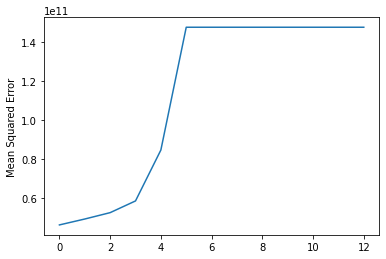

In [67]:
plt.plot(rsss)
plt.ylabel('Mean Squared Error')
plt.show()

In [68]:
minimum_penalty_idx: int = min(range(13), key=lambda x: l1_penalties[x])

In [69]:
min(rsss) == rsss[minimum_penalty_idx]

True

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [75]:
lasso = Lasso(alpha=l1_penalties[minimum_penalty_idx], normalize=True, max_iter=10**5)
lasso.fit(training[all_features], training.price)
lasso.coef_

array([-1.60066393e+04, -0.00000000e+00,  4.35684331e+04,  4.56801338e+02,
       -3.04589893e+04,  4.60683562e-01, -4.86949665e+02, -0.00000000e+00,
        7.92875251e+03,  5.82403254e+05,  3.92276572e+04,  2.17488897e+04,
        1.30496843e+05,  0.00000000e+00,  6.14135778e+00, -3.29797498e+03,
        6.12671662e+00])

In [79]:
len(lasso.coef_[lasso.coef_.nonzero()])

14

In [81]:
len(all_features)

17

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [83]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [87]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model.coefficients['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [97]:
number_of_nnz: list[int] = []

for l1_penalty in l1_penalty_values:
    lasso = Lasso(alpha=l1_penalty)
    lasso.fit(training[all_features], training.price)
    number_of_nnz.append(len(lasso.coef_[lasso.coef_.nonzero()]))

    

In [98]:
number_of_nnz

[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [ ]:
l1_penalty_min = 
l1_penalty_max = 

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [ ]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?